In [121]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import random as rd # random number generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [122]:
df = pd.read_csv('phishing-dataset/PhiUSIIL_Phishing_URL_Dataset.csv')

In [123]:
len(df)

235795

In [124]:
df.head(50)

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.000000,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.000000,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.000000,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.000000,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.000000,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1
5,23107.txt,https://www.globalreporting.org,30,www.globalreporting.org,23,0,org,100.000000,1.000000,0.079963,...,0,0,1,35,1,11,86,0,14,1
6,23034.txt,https://www.saffronart.com,25,www.saffronart.com,18,0,com,100.000000,1.000000,0.522907,...,0,0,1,32,4,14,44,2,17,1
7,696732.txt,https://www.nerdscandy.com,25,www.nerdscandy.com,18,0,com,100.000000,1.000000,0.522907,...,0,0,1,24,2,22,36,0,15,1
8,739255.txt,https://www.hyderabadonline.in,29,www.hyderabadonline.in,22,0,in,100.000000,1.000000,0.005084,...,0,0,1,71,4,9,40,1,317,1
9,14486.txt,https://www.aap.org,18,www.aap.org,11,0,org,100.000000,1.000000,0.079963,...,0,0,1,10,1,12,173,6,65,1


In [125]:
# non-phishing sites
df[df['label'] == 1]

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235789,179093.txt,https://www.life-in-ecuador.com,30,www.life-in-ecuador.com,23,0,com,100.0,0.533333,0.522907,...,0,0,1,43,1,16,42,0,44,1
235790,660997.txt,https://www.skincareliving.com,29,www.skincareliving.com,22,0,com,100.0,1.000000,0.522907,...,1,0,1,51,7,21,187,2,191,1
235791,77185.txt,https://www.winchester.gov.uk,28,www.winchester.gov.uk,21,0,uk,100.0,0.785714,0.028555,...,1,0,0,50,1,7,88,0,31,1
235792,622132.txt,https://www.nononsensedesign.be,30,www.nononsensedesign.be,23,0,be,100.0,1.000000,0.003319,...,0,0,1,27,10,30,58,2,67,1


In [126]:
# phishing sites
df[df['label'] == 0]

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
11,mw42508.txt,http://www.teramill.com,22,www.teramill.com,16,0,com,82.644628,1.000000,0.522907,...,0,0,0,0,0,0,0,0,1,0
20,mw16985.txt,http://www.f0519141.xsph.ru,26,www.f0519141.xsph.ru,20,0,ru,55.284926,0.923077,0.018013,...,0,0,0,0,0,0,0,0,0,0
21,mw131249.txt,http://www.shprakserf.gq,24,www.shprakserf.gq,17,0,gq,56.551141,1.000000,0.000053,...,0,0,0,0,0,0,0,0,0,0
27,7972389.txt,https://service-mitld.firebaseapp.com/,37,service-mitld.firebaseapp.com,29,0,com,64.645264,0.480000,0.522907,...,0,0,0,0,0,0,0,0,0,0
28,mw34096.txt,http://www.kuradox92.lima-city.de,32,www.kuradox92.lima-city.de,26,0,de,45.849802,0.526316,0.032650,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235780,8020762.txt,https://ww.prestamo.enlinea.pe.vpphoangha.vn/,44,ww.prestamo.enlinea.pe.vpphoangha.vn,36,0,vn,34.109109,0.333333,0.001363,...,0,0,0,0,0,0,0,0,0,0
235782,8091639.txt,http://goldenrod-motley-texture.glitch.me/hvwae.htm,51,goldenrod-motley-texture.glitch.me,34,0,me,27.796143,0.322581,0.003638,...,0,0,0,0,0,0,0,0,0,0
235783,8095159.txt,https://bancolombia.com1home0892.repl.co/?2,43,bancolombia.com1home0892.repl.co,32,0,co,47.074830,0.551724,0.005977,...,0,0,0,2,0,4,1,0,1,0
235784,8060468.txt,https://aol-108318.weeblysite.com/,34,aol-108318.weeblysite.com,25,0,com,66.720000,0.809524,0.522907,...,1,0,0,19,3,9,1,0,4,0


In [127]:
df['label'].describe()

count    235795.000000
mean          0.571895
std           0.494805
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

In [128]:
df_cleaned = df.drop(columns='FILENAME')

In [129]:
def split_data(df_total, class_col, pos_label, neg_label, size):
    
    full_pos = df_total[df_total[class_col] == pos_label]
    full_neg = df_total[df_total[class_col] == neg_label]
    
    split_pos_index = round(len(full_pos) * size)
    split_neg_index = round(len(full_neg) * size)
    
    pos1 = full_pos.iloc[:split_pos_index]
    pos2 = full_pos.iloc[split_pos_index:]
    neg1 = full_neg.iloc[:split_neg_index]
    neg2 = full_neg.iloc[split_neg_index:]
    
    return pos1.reset_index(drop=True), pos2.reset_index(drop=True), neg1.reset_index(drop=True), neg2.reset_index(drop=True)

In [130]:
def get_random_indices(num_of_random,len_of_df):
    
    indices = []
    
    for i in range(num_of_random):
        indices.append(rd.randint(0,len_of_df-1))
    
    return indices

In [131]:
def create_train_test_set(pos1, pos2, neg1, neg2, feature_cols, class_col, num_of_rand):
    
    feature_cols = feature_cols.drop(class_col)
    
    random_nc = pd.DataFrame()
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()
    
    random_pos_indices = get_random_indices(num_of_rand,len(pos1))
    random_pos = pos1.iloc[random_pos_indices]
    remaining_pos1 = pos1.drop(random_pos_indices)
    
    random_neg_indices = get_random_indices(num_of_rand,len(neg1))
    random_neg = neg1.iloc[random_neg_indices]
    remaining_neg1 = neg1.drop(random_neg_indices)
    
#     print("Len of indices" , len(random_neg_indices))
    
    full_train_set = pd.concat([random_pos,random_neg])
    
    full_remaining_pos = pd.concat([remaining_pos1,pos2])
    full_remaining_neg = pd.concat([remaining_neg1,neg2])
    full_test_set = pd.concat([full_remaining_pos,full_remaining_neg])
    
    X_train = full_train_set[feature_cols]
    y_train = pd.concat([y_train,full_train_set[class_col]])
    
    X_test = full_test_set[feature_cols]
    y_test = pd.concat([y_test,full_test_set[class_col]])
    
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

In [132]:
df.dtypes

FILENAME                       object
URL                            object
URLLength                       int64
Domain                         object
DomainLength                    int64
IsDomainIP                      int64
TLD                            object
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode  

In [133]:
corr_matrix = df.corr(numeric_only = True)
corr_matrix.style.background_gradient(cmap='coolwarm')

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
URLLength,1.000000,0.243091,0.277272,-0.421104,-0.241104,-0.016656,-0.245215,0.033339,0.071058,0.161980,0.459094,0.127472,0.956047,0.312632,0.835809,0.304379,0.685091,0.474901,0.500387,0.782582,0.199112,0.013117,-0.060636,0.045219,-0.075456,-0.215877,-0.193234,-0.094548,-0.073770,-0.082549,0.029975,-0.005168,-0.149104,-0.010952,-0.044875,-0.035443,-0.180909,-0.067420,-0.072551,0.021561,-0.031734,-0.057816,-0.025163,-0.126420,-0.064639,-0.014507,-0.078643,-0.074722,-0.023206,-0.059055,-0.233445
DomainLength,0.243091,1.000000,-0.041398,-0.420694,-0.577425,0.027209,-0.178104,0.152669,0.399157,0.041643,0.011304,0.021627,0.277602,0.547854,0.131709,0.289628,0.020033,0.064477,0.016320,0.272930,0.182803,-0.019218,-0.075171,0.067131,-0.107133,-0.296493,-0.328603,-0.148317,-0.082594,-0.119737,0.019387,-0.046803,-0.202821,-0.012502,-0.051687,-0.038560,-0.216055,-0.111077,-0.111882,0.009409,-0.039944,-0.065895,-0.034773,-0.196860,-0.083458,-0.017596,-0.102216,-0.096712,-0.031673,-0.070099,-0.283152
IsDomainIP,0.277272,-0.041398,1.000000,-0.121439,-0.101307,-0.053220,-0.111769,-0.011125,0.084619,0.001239,0.000354,0.000977,0.244300,-0.002630,0.224703,0.161257,0.288351,0.389523,0.178814,0.285846,0.115484,-0.011741,-0.016211,0.002159,-0.004602,-0.052033,-0.054458,-0.030890,-0.028261,-0.006481,0.023497,-0.010231,-0.021518,-0.002795,-0.009741,-0.007988,-0.046432,-0.011489,-0.011962,-0.008419,-0.015708,-0.013863,-0.005919,-0.022796,-0.016502,-0.004149,-0.023126,-0.018981,-0.006793,-0.015269,-0.060202
URLSimilarityIndex,-0.421104,-0.420694,-0.121439,1.000000,0.572938,0.162042,0.571622,-0.053915,-0.058481,-0.100159,-0.032257,-0.078989,-0.449120,-0.491761,-0.299591,-0.561238,-0.161075,-0.341722,-0.075346,-0.540554,-0.604885,0.346389,0.231147,-0.078496,0.352123,0.604045,0.543969,0.402334,0.313293,0.433413,-0.060840,-0.049634,0.590195,0.041042,0.191208,0.139202,0.673690,0.448227,0.404655,0.061553,0.151290,0.291542,0.087228,0.613620,0.235728,0.057683,0.315679,0.271590,0.091556,0.221960,0.860358
CharContinuationRate,-0.241104,-0.577425,-0.101307,0.572938,1.000000,0.237221,0.349810,0.051438,-0.482314,-0.036231,-0.004371,-0.021257,-0.252761,-0.304448,-0.158497,-0.343880,-0.068517,-0.145347,-0.034872,-0.425542,-0.711020,0.089170,0.133351,-0.068861,0.164529,0.550943,0.568560,0.213020,0.177268,0.206705,-0.031916,0.019089,0.340722,0.021262,0.127151,0.086036,0.380694,0.245257,0.220213,0.075026,0.095809,0.179145,0.059667,0.345566,0.135931,0.027943,0.183900,0.147881,0.049963,0.121745,0.467735
TLDLegitimateProb,-0.016656,0.027209,-0.053220,0.162042,0.237221,1.000000,0.274224,0.386794,-0.250048,-0.016577,0.001207,-0.010993,-0.004864,0.128466,-0.029101,-0.090831,-0.009376,-0.036019,-0.011255,-0.094307,-0.280275,0.043764,0.041658,-0.025272,0.005597,0.298565,0.296253,0.033452,0.058150,0.081560,-0.008145,-0.036884,0.119061,0.005316,0.093219,0.027294,0.097843,0.063004,0.075440,0.070310,0.085441,0.111494,0.038673,0.114394,0.053432,0.008296,0.058475,0.028216,0.015252,0.033182,0.097389
URLCharProb,-0.245215,-0.178104,-0.111769,0.571622,0.349810,0.274224,1.000000,0.069818,-0.081576,-0.056108,-0.029030,-0.044623,-0.214701,0.045577,-0.290734,-0.708875,-0.103363,-0.193290,-0.055230,-0.307038,-0.396982,0.161159,0.124884,-0.058660,0.156942,0.361329,0.331182,0.216097,0.1

In [134]:
numeric_df = df.select_dtypes(exclude=object)

In [135]:
numeric_df.dtypes

URLLength                       int64
DomainLength                    int64
IsDomainIP                      int64
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode                      int64
LargestLineLength               int64
HasTitle                        int64
DomainTitleMatchScore         float64
URLTitleMatc

In [136]:
# sim_len = 1
# class_col = 'label'
# pos_label = 0
# neg_label = 1
# size = .5
# X_train, y_train, X_test, y_test = run_simulation(sim_len, numeric_df, class_col, pos_label, neg_label, size)

In [137]:
# col_names = X_train.columns.values.tolist()
# label = y_train.columns.values.tolist()

# print("Cols", col_names)
# print("Label", label)

In [138]:
# clf = DecisionTreeClassifier(criterion='entropy') # Initialize the decision tree classifier
# clf.fit(X_train, y_train) # Fitting the classifier on the training data

# col_names = X_train.columns
# label = y_train.columns[0]
# plot_tree(clf)

# # print("Cols", feature_names)
# # print("Label", label)
# # dot_data = tree.export_graphviz(clf, out_file=None) 
# # graph = graphviz.Source(dot_data) 
# # graph.render("Phishing")
# # dot_data = tree.export_graphviz(clf, out_file=None,
# #                                 feature_names=col_names,  
# #                                 class_names=label,  
# #                                 filled=True, rounded=True,  
# #                                 special_characters=True) 
# # graph = graphviz.Source(dot_data)  
# # graph


In [139]:
def get_entropy(info):
    
    text = str(info)
    
    parts = text.split('entropy = ')[1]
    entropy_value = parts.split('\\n')[0]

    # Convert the entropy value to a float
    return float(entropy_value)

In [140]:
def get_num_of_samples(info):
    
    text = str(info)
    
    parts = text.split('samples = ')[1]
    sample_value = parts.split('\\n')[0]

    # Convert the entropy value to a float
    return float(sample_value)

In [141]:
from sklearn import tree
def model_metrics(X_train, y_train):
    
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1) # Initialize the decision tree classifier
    clf.fit(X_train, y_train) # Fitting the classifier on the training data
    
    col_names = X_train.columns
    label = y_train.columns[0]
    
    info = plot_tree(clf, feature_names=col_names, class_names=[str(pos_label), str(neg_label)], rounded=True, filled=True)
    
    metrics = {
        'Graph' : info,
        'Tree': clf,
        'e_parent': get_entropy(info[0]),
        'e_child1': get_entropy(info[1]),
        'e_child2' : get_entropy(info[3]),
        'parent_sample' : get_num_of_samples(info[0]),
        'child_sample1' : get_num_of_samples(info[1]),
        'child_sample2' : get_num_of_samples(info[3]),
    }

#     plot_tree(clf, feature_names=col_names, class_names=[str(pos_label), str(neg_label)], rounded=True, filled=True)
#     plt.show()
    
    return metrics

In [142]:
def calculate_information_gain(metrics):
    
    return metrics['e_parent']-((metrics['child_sample1']/metrics['parent_sample'])*metrics['e_child1'])-((metrics['child_sample2']/metrics['parent_sample'])*metrics['e_child2'])

In [143]:
def get_information_gain(X_train, y_train, label_col, columns):
    
    information_gain_weights = pd.DataFrame()
    col_names = columns[:-1]
    current_information_gain = np.array([])

    
    for col in columns:
        if col != label_col:
            metrics = model_metrics(X_train[[col]], y_train)
            current_information_gain = np.append(current_information_gain, calculate_information_gain(metrics))
    current_information_gain = current_information_gain.reshape(1,-1)
    information_gain_weights = pd.DataFrame(current_information_gain, columns=col_names)

    return information_gain_weights

        

In [144]:
def get_avg_info_gain_df(df_gain):
    # Compute the mean of each column in the DataFrame
    avg_info_gain = df_gain.mean()
    
    # Convert the resulting Series to a NumPy array
    avg_info_gain_array = avg_info_gain.to_numpy()
    
    # Create a DataFrame from the average coefficients
    avg_info_gain_df = pd.DataFrame([avg_info_gain], columns=df_gain.columns, index=['avg'])
    
    # Concatenate the original DataFrame with the average coefficients DataFrame
    result_df = pd.concat([df_gain, avg_info_gain_df], ignore_index=False)
    
    return result_df, avg_info_gain_array

In [145]:
def run_simulation(sim_len, df_total, label_col,pos_label, neg_label, size, num_of_rand):
    
    sim_info_gain = pd.DataFrame()
    
    phishing1, phishing2, non_phishing1, non_phishing2 = split_data(df_total, label_col, pos_label, neg_label, size)

    
    for i in range(sim_len):
        
        X_train, y_train, X_test, y_test = create_train_test_set(phishing1, phishing2, non_phishing1, non_phishing2, df_total.columns, label_col, num_of_rand)
        
        info_gain = get_information_gain(X_train, y_train, label_col, df_total.columns)
        
        sim_info_gain = pd.concat([info_gain, sim_info_gain])
        
    avg_info_gain_df, avg_info_gain_array = get_avg_info_gain_df(sim_info_gain)
        
    return avg_info_gain_df, avg_info_gain_array, X_test, y_test, X_train, y_train
    

In [146]:
def mod_run_simulation(sim_len, df_total, label_col,pos_label, neg_label, size, num_of_rand):

    sim_explained_variance = pd.DataFrame()
    
    pca = PCA(n_components=13)
    pc = pca.fit_transform(df_heart_standardized.iloc[:-1])

    df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                        'principal component 4', 'principal component 5', 'principal component 6',
                                        'principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13'])

    final_pca_df = pd.concat([df_pca, df_heart_standardized[['num']]], axis = 1)

    phishing1, phishing2, non_phishing1, non_phishing2 = split_data(final_pca_df, label_col, pos_label, neg_label, size)

    for i in range(sim_len):

        X_train, y_train, X_test, y_test = create_train_test_set(phishing1, phishing2, non_phishing1, non_phishing2, final_pca_df.columns, label_col, num_of_rand)

        explained_variance = get_explained_variance(pca,df_pca.columns)
        sim_explained_variance = pd.concat([explained_variance, sim_explained_variance])
    

    avg_explained_variance_df, avg_explained_variance_array = get_avg_explained_variance_df(sim_explained_variance)

    return avg_explained_variance_df, avg_explained_variance_array, X_test, y_test, X_train, y_train


In [147]:
def get_explained_variance(pca,feature_cols):
    
    explained_variance= pca.explained_variance_ratio_
    explained_variance = explained_variance.reshape(1,-1)

    ev_df = pd.DataFrame(explained_variance, columns=feature_cols)
    
    return ev_df



In [148]:
def get_avg_explained_variance_df(df_ev):
    # Compute the mean of each column in the DataFrame
    avg_ev = df_ev.mean()

    # Convert the resulting Series to a NumPy array
    avg_ev_array = avg_ev.to_numpy()

    # Create a DataFrame from the average coefficients
    avg_ev_df = pd.DataFrame([avg_ev], columns=df_ev.columns, index=['avg'])

    # Concatenate the original DataFrame with the average coefficients DataFrame
    result_df = pd.concat([df_ev, avg_ev_df], ignore_index=False)

    return result_df, avg_ev_array

IndexError: list index out of range

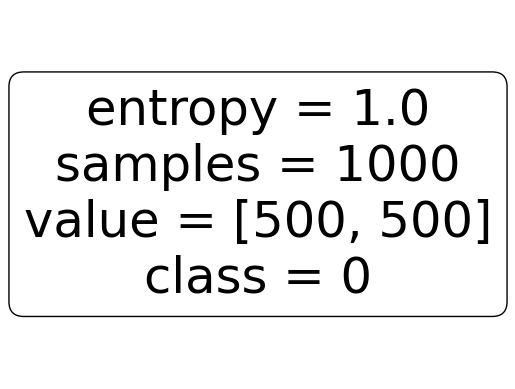

In [149]:
sim_len = 2
label_col = 'label'
pos_label = 0
neg_label = 1
size = .5
num_of_rand = 500
avg_info_gain_df, avg_info_gain_array, X_test, y_test,X_train, hy_train= run_simulation(sim_len, numeric_df, label_col, pos_label, neg_label, size, num_of_rand)


In [30]:
avg_info_gain_df

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,0.189284,0.079580,0.0050,0.973341,0.152520,0.060802,0.143448,0.013528,0.072724,0.0050,...,0.038736,0.137731,0.013419,0.421485,0.741824,0.584586,0.640644,0.734296,0.301653,0.771354
0,0.197304,0.078328,0.0020,0.973341,0.135834,0.079169,0.143256,0.022056,0.060826,0.0020,...,0.033430,0.150489,0.020817,0.474627,0.703760,0.581186,0.632800,0.753650,0.269309,0.789192
avg,0.193294,0.078954,0.0035,0.973341,0.144177,0.069986,0.143352,0.017792,0.066775,0.0035,...,0.036083,0.144110,0.017118,0.448056,0.722792,0.582886,0.636722,0.743973,0.285481,0.780273


In [31]:
alpha = .316
count = 0
swagger = []
indices = []  # Array to store the indices

for idx, ig in enumerate(avg_info_gain_array):
    
    if (((ig / .96) **2) < alpha):
        count += 1
        indices.append(idx)
    else: 
        swagger.append(ig)
print(f"Number of IG lower than {alpha:.6f}: {count:.2f}")

Number of IG lower than 0.316000: 42.00


In [32]:
print(swagger)

[np.float64(0.973341), np.float64(0.7809090000000001), np.float64(0.593014), np.float64(0.7227919999999999), np.float64(0.582886), np.float64(0.636722), np.float64(0.743973), np.float64(0.780273)]


In [33]:
column_names = [
  'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

df_heart = pd.read_csv('heartdiseaes/processed.cleveland.data', names = column_names, index_col = False)

new_row_values = [63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3.0, 0, 6.0, 0]

df_heart.loc[0] = new_row_values

In [34]:
for i in df_heart.itertuples():
    tup = i
    for j in tup:
        if j == '?':
            print(tup)

Pandas(Index=87, age=53.0, sex=0.0, cp=3.0, trestbps=128.0, chol=216.0, fbs=0.0, restecg=2.0, thalach=115.0, exang=0.0, oldpeak=0.0, slope=1.0, ca='0.0', thal='?', num=0)
Pandas(Index=166, age=52.0, sex=1.0, cp=3.0, trestbps=138.0, chol=223.0, fbs=0.0, restecg=0.0, thalach=169.0, exang=0.0, oldpeak=0.0, slope=1.0, ca='?', thal='3.0', num=0)
Pandas(Index=192, age=43.0, sex=1.0, cp=4.0, trestbps=132.0, chol=247.0, fbs=1.0, restecg=2.0, thalach=143.0, exang=1.0, oldpeak=0.1, slope=2.0, ca='?', thal='7.0', num=1)
Pandas(Index=266, age=52.0, sex=1.0, cp=4.0, trestbps=128.0, chol=204.0, fbs=1.0, restecg=0.0, thalach=156.0, exang=1.0, oldpeak=1.0, slope=2.0, ca='0.0', thal='?', num=2)
Pandas(Index=287, age=58.0, sex=1.0, cp=2.0, trestbps=125.0, chol=220.0, fbs=0.0, restecg=0.0, thalach=144.0, exang=0.0, oldpeak=0.4, slope=2.0, ca='?', thal='7.0', num=0)
Pandas(Index=302, age=38.0, sex=1.0, cp=3.0, trestbps=138.0, chol=175.0, fbs=0.0, restecg=0.0, thalach=173.0, exang=0.0, oldpeak=0.0, slope=1

In [35]:
row_nums = [87,166,192,266,287,302]
df_heart = df_heart.drop(row_nums)

In [36]:
df_heart.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

In [37]:
df_heart['ca'] = pd.to_numeric(df_heart['ca'])

In [38]:
df_heart['thal'] = pd.to_numeric(df_heart['thal'])

In [39]:
df_heart['num'] = df_heart['num'].replace([1,2,3,4], 1)

In [40]:
def standardizer(df):
    
    temp_df = df.copy()
    
    for col in temp_df.columns[:-1]:
        
        temp_df[col] = (temp_df[col] - temp_df[col].mean())/temp_df[col].std()
        
    return temp_df

In [41]:
df_heart_standardized = standardizer(df_heart)

In [42]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [43]:
df_heart_standardized.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.934603,0.689930,-2.236854,0.749116,-0.275978,2.426332,1.008496,0.017465,-0.695246,1.067164,2.260330,-0.720760,0.654772,0
1,1.376605,0.689930,0.872408,1.593577,0.743301,-0.410757,1.008496,-1.813274,1.433497,0.381130,0.642696,2.474249,-0.892713,1
2,1.376605,0.689930,0.872408,-0.658320,-0.352904,-0.410757,1.008496,-0.897904,1.433497,1.324427,0.642696,1.409246,1.170601,1
3,-1.938409,0.689930,-0.164013,-0.095345,0.050961,-0.410757,-1.001728,1.630258,-0.695246,2.096215,2.260330,-0.720760,-0.892713,0
4,-1.496407,-1.444542,-1.200433,-0.095345,-0.833696,-0.410757,1.008496,0.976423,-0.695246,0.295376,-0.974938,-0.720760,-0.892713,0


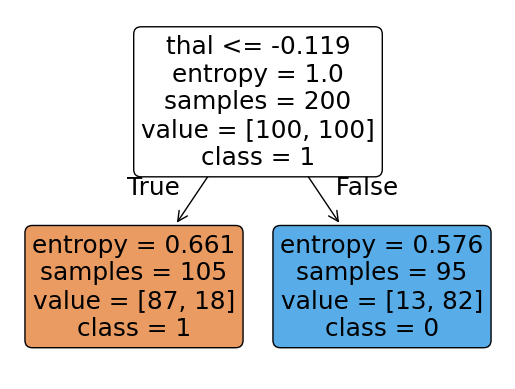

In [44]:
sim_len = 100
label_col = 'num'
pos_label = 1
neg_label = 0
size = .5
num_of_rand = 100
heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)

In [45]:
len(heart_X_train)

200

In [46]:
len(heart_y_train)

200

In [47]:
len(heart_X_test)

182

In [48]:
len(heart_y_test)

182

In [49]:
# heart_avg_info_gain_df

In [50]:
# heart_avg_info_gain_array

In [51]:
# alpha = .1
# count = 0
# heart_swagger = []
# heart_indices = []  # Array to store the indices

# for idx, ig in enumerate(heart_avg_info_gain_array):
#     if ((ig / .34) ** 2 < alpha):
#         count += 1
#         heart_indices.append(idx)  # Append the index
#     else: 
#         heart_swagger.append(ig)
# print(f"Number of IG lower than {alpha:.6f}: {count:.2f}")

<p>1st process is getting sqaured difference </p>
<p>2nd weights dot squared diff </p>
<p>3rd sort resulting list</p>
<p>4th return k neighbors </p>
<p> 5th classify</p>

In [52]:
#a and b are rows here. 
def Euclid_Distance(a,b,weights,Columns,Class):
    c=Columns 
    D=0
    for i in range(len(c)-1):
        if c[i]!=Class:
            D+=(weights[i]**2)*(float(a[c[i]])-float(b[c[i]]))**2
    return D**0.5


def Nearest_Neighbors(point,List_Pot_Nbrs,weights,Class_Col_Name):
    ClassWithDistance=[]
    d=0
    for n in range(len(List_Pot_Nbrs)):
        d=Euclid_Distance(point,List_Pot_Nbrs.iloc[n],weights,List_Pot_Nbrs.columns,Class_Col_Name)
        ClassWithDistance+=[[d,List_Pot_Nbrs.iloc[n][Class_Col_Name]]]
    sorted_list = sorted(ClassWithDistance, key=lambda x: x[0])
    
    return sorted_list

def KNN(k,Sorted_List):
    Sum=0
    for i in range(k):
        if Sorted_List[i][1]==1:
            Sum+=1
    if Sum>k/2:
        return 1
    else:
        return 0
    
def ConfusionMatrix(TrP,TrN,FaP,FaN):
    print("         Confusion Matrix")
    print("TN,FP: ",TrN, "    ,    ", FaP)
    print("FN,TP: ",FaN,"     ,    ", TrP)


In [53]:
def specificity_score(TN,FP):
    
    return TN/(TN+FP)

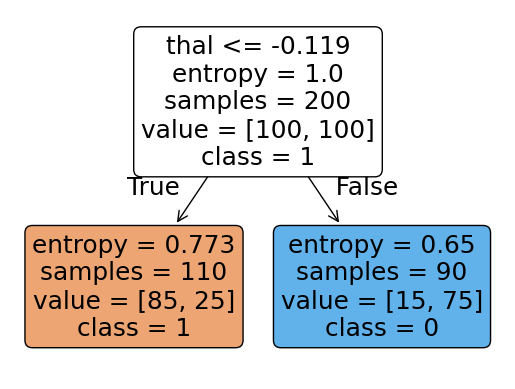

In [54]:
from sklearn.metrics import confusion_matrix

avg_acc = []
avg_precision = []
avg_recall = []
avg_f1 = []
avg_specificity = []

weight_avg_acc = []
weight_avg_precision = []
weight_avg_recall = []
weight_avg_f1 = []
weight_avg_specificity = []

dropped_weight_avg_acc = []
dropped_weight_avg_precision = []
dropped_weight_avg_recall = []
dropped_weight_avg_f1 = []
dropped_weight_avg_specificity = []

pca_avg_acc = []
pca_avg_precision = []
pca_avg_recall = []
pca_avg_f1 = []
pca_avg_specificity = []

pca_explained_variance_acc = []
pca_explained_variance_precision = []
pca_explained_variance_recall = []
pca_explained_variance_f1 = []
pca_explained_variance_specificity = []

NN_acc = []
NN_precision = []
NN_recall = []
NN_f1 = []
NN_specificity = []

RFC_acc = []
RFC_precision = []
RFC_recall = []
RFC_f1 = []
RFC_specificity = []

XGB_acc = []
XGB_precision = []
XGB_recall = []
XGB_f1 = []
XGB_specificity = []

sim_len = 50
label_col = 'num'
pos_label = 1
neg_label = 0
size = .5
num_of_rand = 100

heart_swagger = []

for i in range(sim_len):
    
    
    heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)
    Train_Data =  pd.concat([heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([heart_X_test, heart_y_test], axis=1)
    
    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1,1,1,1,1,1,1], "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_non_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_non_weighted = TP/(TP+FP)
    recall_non_weighted = TP/(TP+FN)
    f1_non_weighted = (2 * precision_non_weighted * recall_non_weighted)/(precision_non_weighted+recall_non_weighted)
    specificity_non_weighted = specificity_score(TN,FP)
    
    
#     print("Accurecy:", A)
#     ConfusionMatrix(TP,TN,FP,FN)
    avg_acc.append(A_non_weighted*100)
    avg_precision.append(precision_non_weighted*100)
    avg_recall.append(recall_non_weighted*100)
    avg_f1.append(f1_non_weighted*100)
    avg_specificity.append(specificity_non_weighted*100)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data,  heart_avg_info_gain_array, "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_weighted = TP/(TP+FP)
    recall_weighted = TP/(TP+FN)
    f1_weighted = (2 * precision_weighted * recall_weighted)/(precision_weighted+recall_weighted)
    specificity_weighted = specificity_score(TN,FP)

    weight_avg_acc.append(A_weighted*100)
    weight_avg_precision.append(precision_weighted*100)
    weight_avg_recall.append(recall_weighted*100)
    weight_avg_f1.append(f1_weighted*100)
    weight_avg_specificity.append(specificity_weighted*100)
    

    alpha = .1
    count = 0
    heart_swagger = []
    heart_indices = []  # Array to store the indices

    for idx, ig in enumerate(heart_avg_info_gain_array):
        if ((ig / max(heart_avg_info_gain_array)) ** 2 < alpha):
            count += 1
            heart_indices.append(idx)  # Append the index
        else:
            heart_swagger.append(ig)

    dropped_heart_X_train = heart_X_train.drop(heart_X_train.columns[heart_indices],axis=1)
    dropped_heart_X_test = heart_X_test.drop(heart_X_test.columns[heart_indices],axis=1)

    Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_dropped_weighted = TP/(TP+FP)
    recall_dropped_weighted = TP/(TP+FN)
    f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
    specificity_dropped_weighted = specificity_score(TN,FP)

    dropped_weight_avg_acc.append(A_dropped_weighted*100)
    dropped_weight_avg_precision.append(precision_dropped_weighted*100)
    dropped_weight_avg_recall.append(recall_dropped_weighted*100)
    dropped_weight_avg_f1.append(f1_dropped_weighted*100)
    dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)

    pca = PCA(n_components=7)
    pc = pca.fit_transform(heart_X_train)
    pca2 = PCA(n_components=7)
    pc2 = pca.fit_transform(heart_X_test)

    df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                            'principal component 4', 'principal component 5', 'principal component 6',
                                            'principal component 7'])
    df_pca2 = pd.DataFrame(data=pc2, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                          'principal component 4', 'principal component 5', 'principal component 6',
                                          'principal component 7'])

    final_train_pca_df = pd.concat([df_pca, heart_y_train[['num']]], axis = 1)
    final_test_pca_df = pd.concat([df_pca2, heart_y_train[['num']]], axis = 1)

    Train_Data =  final_train_pca_df
    Test_Data = final_test_pca_df

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1,1,1,1,1,1,1] , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    
    A_pca=(TP+TN)/(TP+TN+FP+FN)
    precision_pca = TP/(TP+FP)
    recall_pca = TP/(TP+FN)
    f1_pca = (2 * precision_pca * recall_pca)/(precision_pca+recall_pca)
    specificity_pca = specificity_score(TN,FP)

    pca_avg_acc.append(A_pca*100)
    pca_avg_precision.append(precision_pca*100)
    pca_avg_recall.append(recall_pca*100)
    pca_avg_f1.append(f1_pca*100)
    pca_avg_specificity.append(specificity_pca*100)
    

    ev_heart_avg_ev_df, ev_heart_avg_ev_array, ev_heart_X_test, ev_heart_y_test, ev_heart_X_train, ev_heart_y_train = mod_run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)


    alpha = .1
    count = 0
    ev_heart_swagger = []
    ev_heart_indices = []  # Array to store the indices

    for idx, ev in enumerate(ev_heart_avg_ev_array):
        if ev < (alpha ** 1 / 2)*max(ev_heart_avg_ev_array):
            count += 1
            ev_heart_indices.append(idx)  # Append the index
        else:
            ev_heart_swagger.append(ev)

    ev_dropped_heart_X_train = ev_heart_X_train.drop(ev_heart_X_train.columns[ev_heart_indices],axis=1)
    ev_dropped_heart_X_test = ev_heart_X_test.drop(ev_heart_X_test.columns[ev_heart_indices],axis=1)

    Train_Data =  pd.concat([ev_dropped_heart_X_train, ev_heart_y_train], axis=1)
    Test_Data = pd.concat([ev_dropped_heart_X_test, ev_heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, ev_heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_pca_ev=(TP+TN)/(TP+TN+FP+FN)
    precision_pca_ev = TP/(TP+FP)
    recall_pca_ev = TP/(TP+FN)
    f1_pca_ev = (2 * precision_pca_ev * recall_pca_ev)/(precision_pca_ev+recall_pca_ev)
    specificity_pca_ev = specificity_score(TN,FP)

    pca_explained_variance_acc.append(A_pca*100)
    pca_explained_variance_precision.append(precision_pca*100)
    pca_explained_variance_recall.append(recall_pca*100)
    pca_explained_variance_f1.append(f1_pca*100)
    pca_explained_variance_specificity.append(specificity_pca*100)

    clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,
                           hidden_layer_sizes=(5, 2), max_iter=1000, random_state=1)
    clf_NN.fit(dropped_heart_X_train, heart_y_train.values.ravel())
    
    NN_prediction = clf_NN.predict(dropped_heart_X_test)

    TN, FP, FN, TP = confusion_matrix(heart_y_test, NN_prediction, labels=[0, 1]).ravel()
    
    NN_acc.append(accuracy_score(heart_y_test, NN_prediction) * 100)
    NN_precision.append(precision_score(heart_y_test, NN_prediction) * 100)
    NN_recall.append(recall_score(heart_y_test, NN_prediction) * 100)
    NN_f1.append(f1_score(heart_y_test, NN_prediction) * 100)
    NN_specificity.append(specificity_score(TN, FP) * 100)
    

    clf_RFC = RandomForestClassifier(max_depth=2, random_state=0)
    clf_RFC.fit(dropped_heart_X_train, heart_y_train.values.ravel())

    RFC_prediction = clf_NN.predict(dropped_heart_X_test)

    TN, FP, FN, TP = confusion_matrix(heart_y_test, RFC_prediction, labels=[0, 1]).ravel()
    
    RFC_acc.append(accuracy_score(heart_y_test, RFC_prediction) * 100)
    RFC_precision.append(precision_score(heart_y_test, RFC_prediction) * 100)
    RFC_recall.append(recall_score(heart_y_test, RFC_prediction) * 100)
    RFC_f1.append(f1_score(heart_y_test, RFC_prediction) * 100)
    RFC_specificity.append(specificity_score(TN, FP) * 100)

    clf_XGB = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

    clf_XGB.fit(dropped_heart_X_train, heart_y_train.values.ravel())
    
    XGB_prediction = clf_XGB.predict(dropped_heart_X_test)

    TN, FP, FN, TP = confusion_matrix(heart_y_test, XGB_prediction, labels=[0, 1]).ravel()
    
    XGB_acc.append(accuracy_score(heart_y_test, XGB_prediction) * 100)
    XGB_precision.append(precision_score(heart_y_test, XGB_prediction) * 100)
    XGB_recall.append(recall_score(heart_y_test, XGB_prediction) * 100)
    XGB_f1.append(f1_score(heart_y_test, XGB_prediction) * 100)
    XGB_specificity.append(specificity_score(TN, FP) * 100)
    
    
    

In [55]:
# clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                        hidden_layer_sizes=(5, 2), random_state=1)
# 
# clf_NN.fit(dropped_heart_X_train, heart_y_train.values.ravel())
# 
# accuracy_score(heart_y_test, clf_NN.predict(dropped_heart_X_test))

<h1 style="text-align:center;"> Womp Womp our k-NN Only</h1>

In [56]:
# dropped_weight_acc = []
# for i in range(sim_len):
# 
#     heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)
# 
# 
#     alpha = .1
#     count = 0
#     heart_swagger = []
#     heart_indices = []  # Array to store the indices
# 
#     for idx, ig in enumerate(heart_avg_info_gain_array):
#         if ((ig / max(heart_avg_info_gain_array)) ** 2 < alpha):
#             count += 1
#             heart_indices.append(idx)  # Append the index
#         else:
#             heart_swagger.append(ig)
# 
#     dropped_heart_X_train = heart_X_train.drop(heart_X_train.columns[heart_indices],axis=1)
#     dropped_heart_X_test = heart_X_test.drop(heart_X_test.columns[heart_indices],axis=1)
# 
#     Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
#     Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)
# 
#     TP=0
#     TN=0
#     FP=0
#     FN=0
# 
# 
#     for p in range(len(Test_Data)):
#         point=Test_Data.iloc[p]
#         NBRS=Nearest_Neighbors(point, Train_Data, heart_swagger , "num")
#         Label=KNN(3,NBRS)
#         if (Label==point["num"] and Label==1):
#             TP+=1
#         if (Label==point["num"] and Label==0):
#             TN+=1
#         if (Label!=point["num"] and Label==1):
#             FP+=1
#         if (Label!=point["num"] and Label==0):
#             FN+=1
#     A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
#     # precision_dropped_weighted = TP/(TP+FP)
#     # recall_dropped_weighted = TP/(TP+FN)
#     # f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
#     # specificity_dropped_weighted = TN/(TN+FP)
# 
#     dropped_weight_acc.append(A_dropped_weighted*100)
#     # dropped_weight_avg_precision.append(precision_dropped_weighted*100)
#     # dropped_weight_avg_recall.append(recall_dropped_weighted*100)
#     # dropped_weight_avg_f1.append(f1_dropped_weighted*100)
#     # dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)

In [57]:
# pca = PCA(n_components=13)
# pc = pca.fit_transform(df_heart_standardized.iloc[:-1])
# 
# df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
#                                         'principal component 4', 'principal component 5', 'principal component 6',
#                                         'principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13'])
# 
# final_pca_df = pd.concat([df_pca, df_heart_standardized[['num']]], axis = 1)
# 
# final_pca_df.head()

<h1 style="text-align:center;">Accuracy</h1>


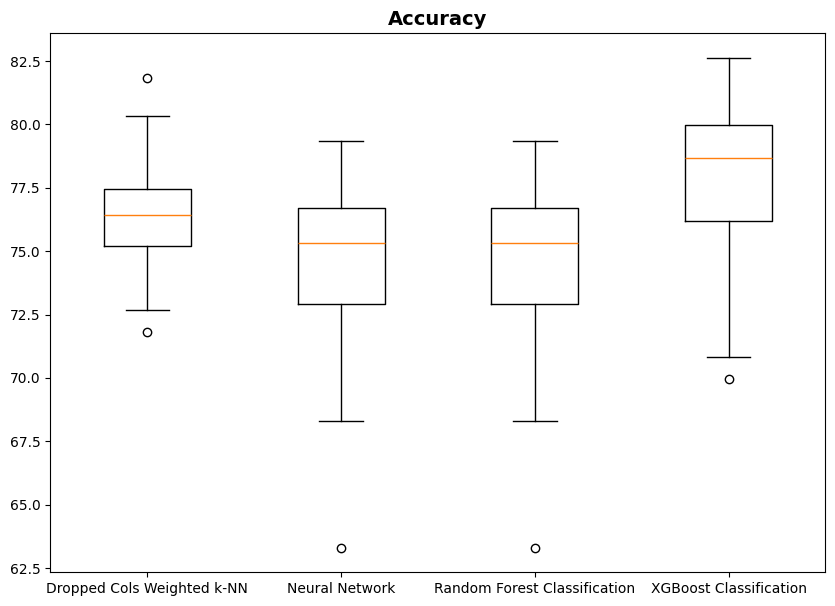

In [58]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')

data = [dropped_weight_avg_acc, NN_acc, RFC_acc, XGB_acc]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Accuracy.svg')

# show plot
plt.show()

<h1 style="text-align:center;">Specificity</h1>


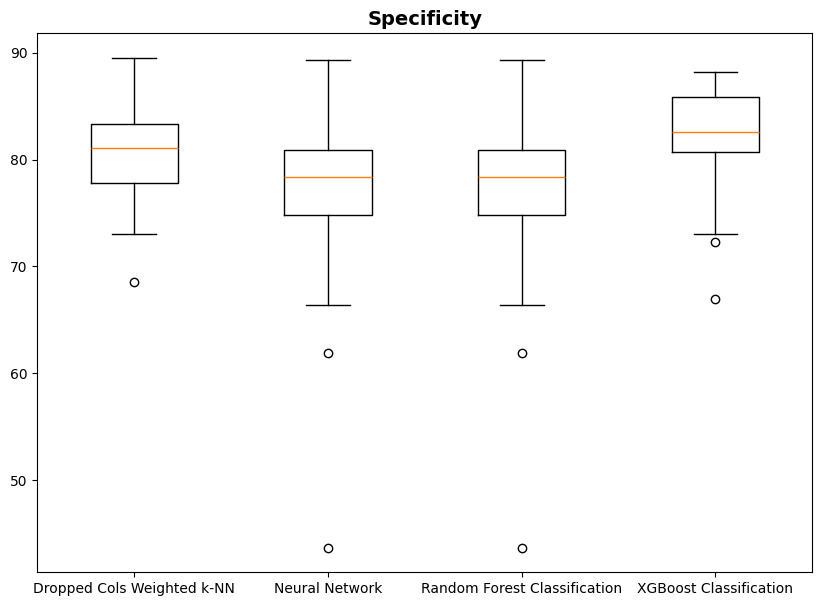

In [59]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_specificity, NN_specificity, RFC_specificity , XGB_specificity]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Specificity.svg')
# show plot
plt.show()

<h1 style="text-align:center;">F1</h1>


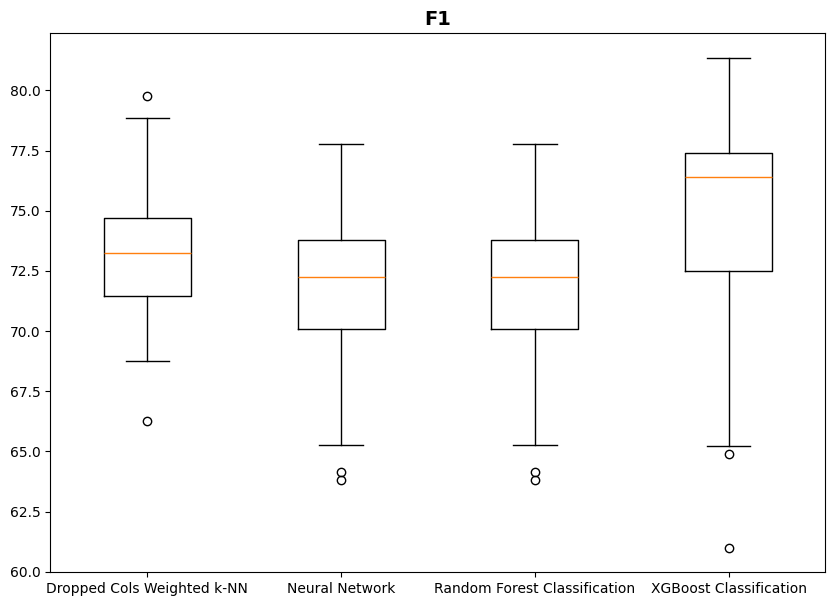

In [60]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_f1, NN_f1, RFC_f1 , XGB_f1]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('F1.svg')
# show plot
plt.show()

<h1 style="text-align:center;">Recall</h1>

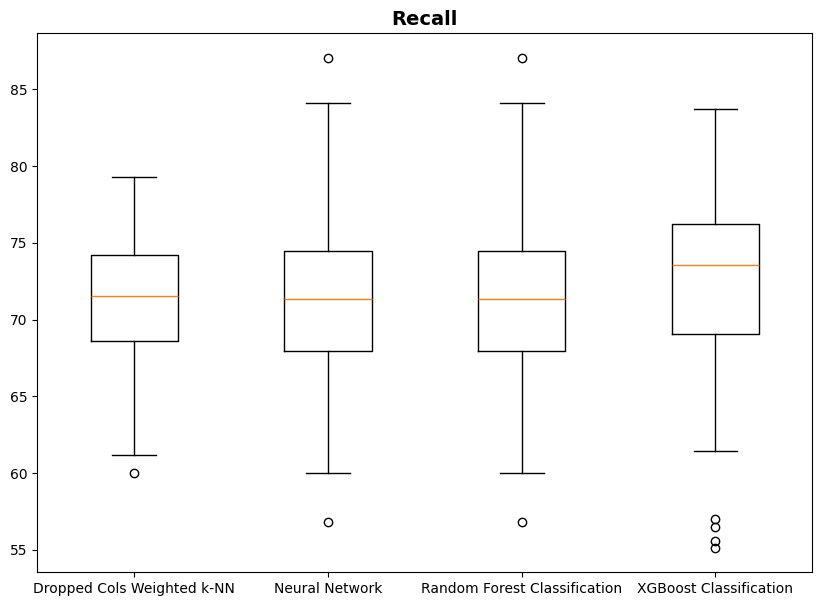

In [61]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_recall, NN_recall, RFC_recall , XGB_recall]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Recall.svg')
# show plot
plt.show()

<h1 style=text-align:center;>Precision</h1>

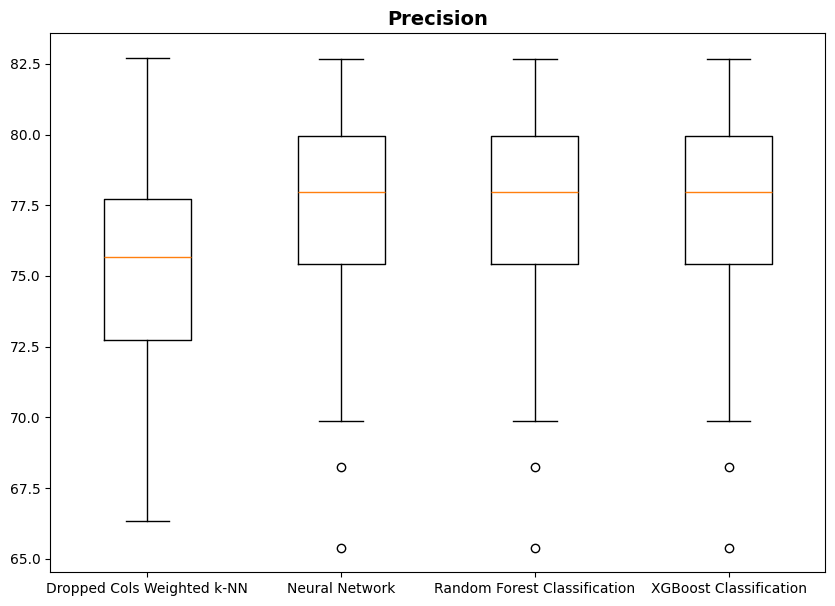

In [62]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [dropped_weight_avg_precision,XGB_precision, XGB_precision , XGB_precision]

x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Precision.svg')
# show plot
plt.show()

In [63]:
# fig = plt.figure(figsize =(10, 7))
# plt.title("Accuracy",fontsize=14, fontweight='bold')
# 
# data = [dropped_weight_acc, NN_acc, RFC_acc, XGB_acc]
# 
# x_axis = ['Dropped Cols Weighted k-NN', 'Neural Network', 'Random Forest Classification', 'XGBoost Classification']
# 
# # Creating plot
# plt.boxplot(data, tick_labels=x_axis)
# 
# # plt.savefig('Accuracy.svg')
# 
# # show plot
# plt.show()

In [64]:
import statistics
statistics.mean(avg_acc)

77.99314295274988

In [65]:
statistics.mean(NN_acc)

74.70397110032505

<h1 style="text-align:center;">These are the Boxplots Including Regular PCA</h1>


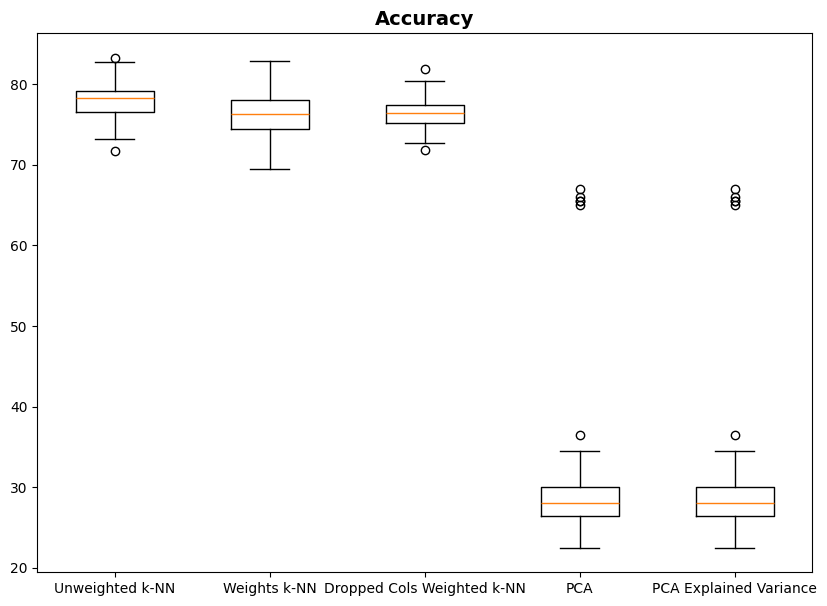

In [66]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')


data = [avg_acc,weight_avg_acc ,dropped_weight_avg_acc, pca_avg_acc, pca_explained_variance_acc]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Accuracy.svg')

# show plot
plt.show()

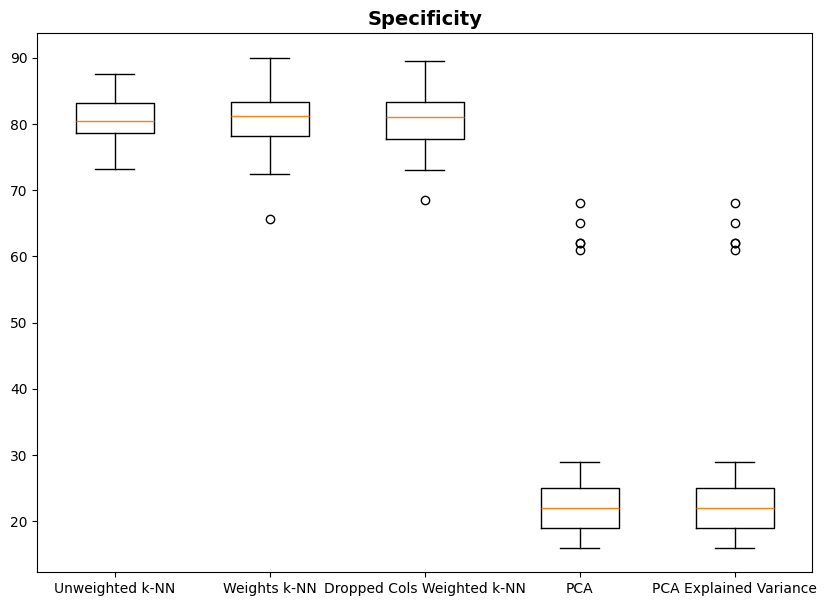

In [67]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [avg_specificity, weight_avg_specificity, dropped_weight_avg_specificity, pca_avg_specificity, pca_explained_variance_specificity]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Specificity.svg')
# show plot
plt.show()

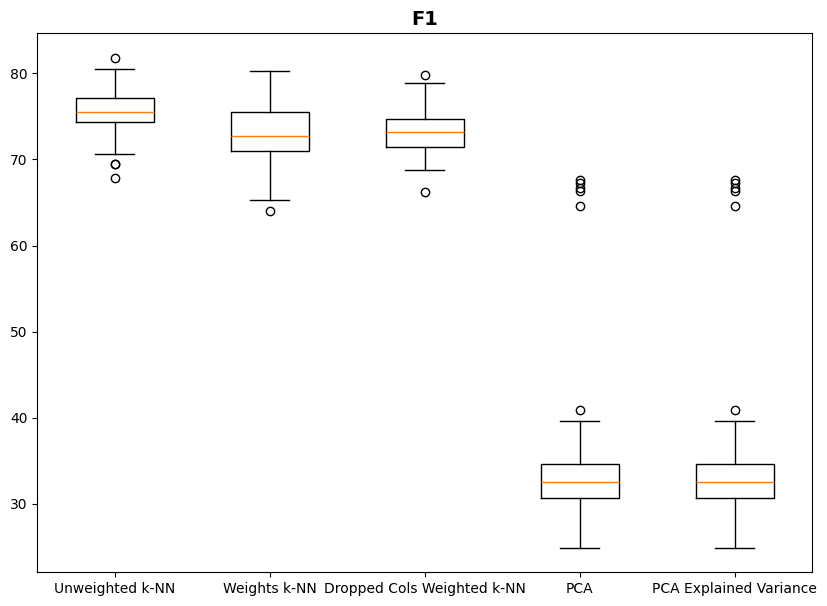

In [68]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [avg_f1, weight_avg_f1, dropped_weight_avg_f1, pca_avg_f1, pca_explained_variance_f1]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('F1.svg')

# show plot
plt.show()

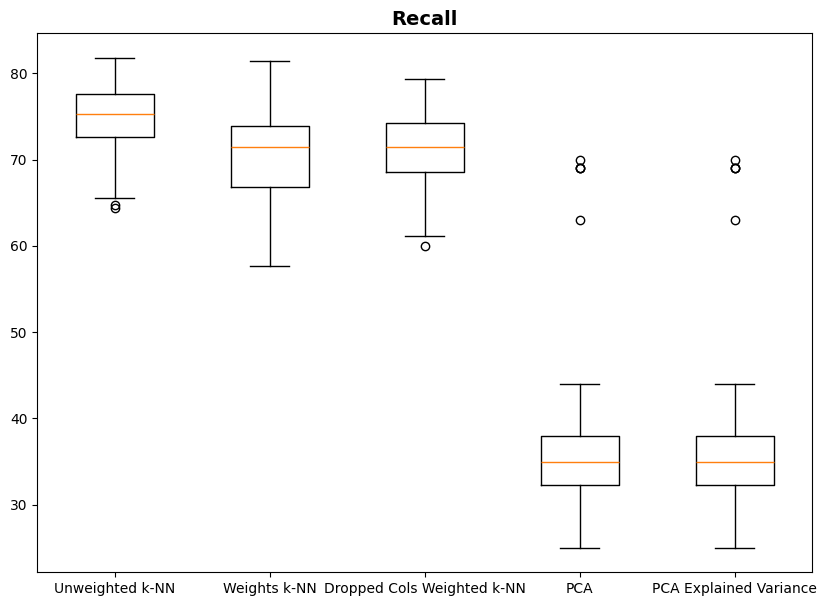

In [69]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [avg_recall,weight_avg_recall, dropped_weight_avg_recall, pca_avg_recall, pca_explained_variance_recall]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Recall.svg')

# show plot
plt.show()

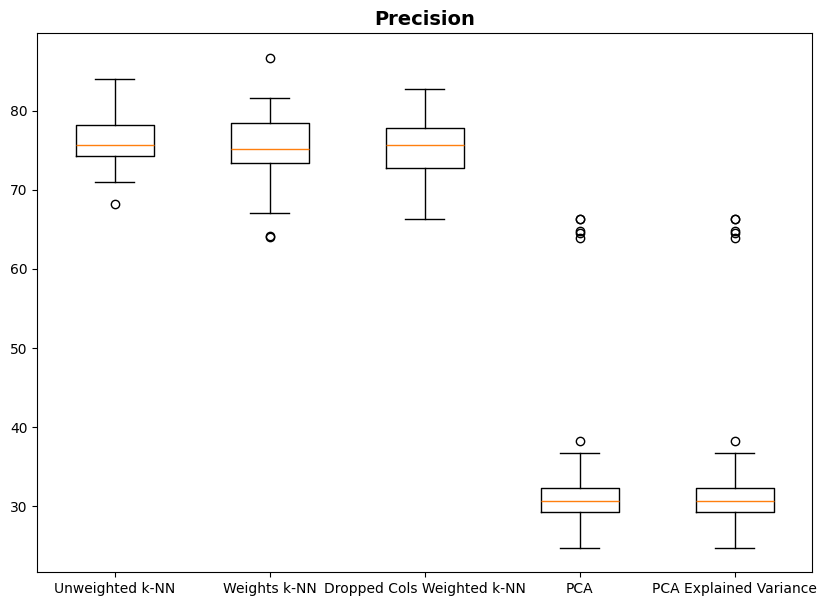

In [70]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [avg_precision, weight_avg_precision, dropped_weight_avg_precision, pca_avg_precision, pca_explained_variance_precision]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Precision.svg')

# show plot
plt.show()

<h1 style="text-align:center;">These are the Boxplots Without Regular PCA</h1>

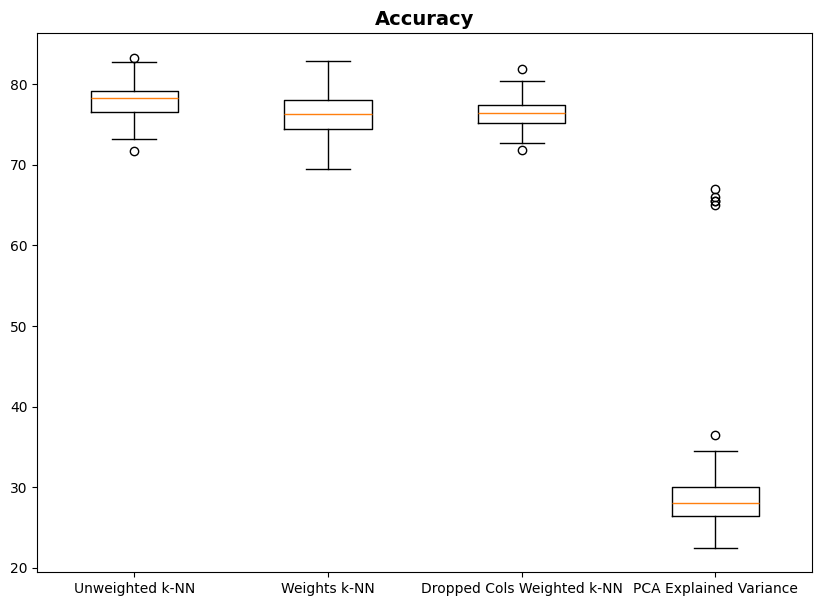

In [71]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')


data = [avg_acc,weight_avg_acc ,dropped_weight_avg_acc,pca_explained_variance_acc]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

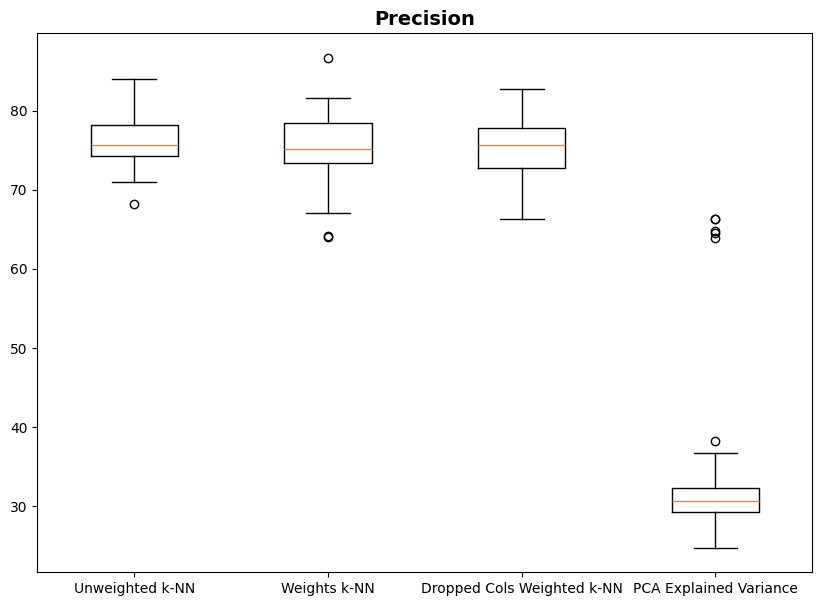

In [72]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [avg_precision,weight_avg_precision ,dropped_weight_avg_precision,pca_explained_variance_precision]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

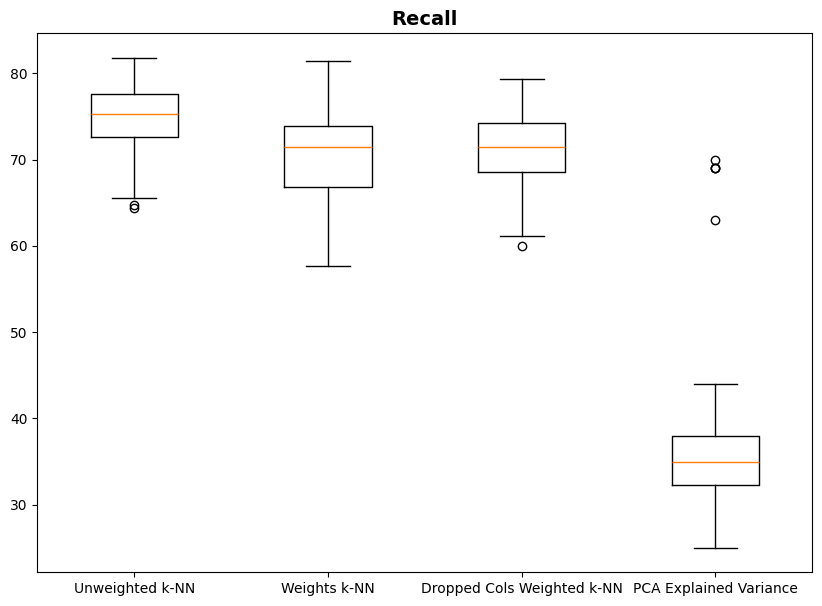

In [73]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [avg_recall,weight_avg_recall ,dropped_weight_avg_recall,pca_explained_variance_recall]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

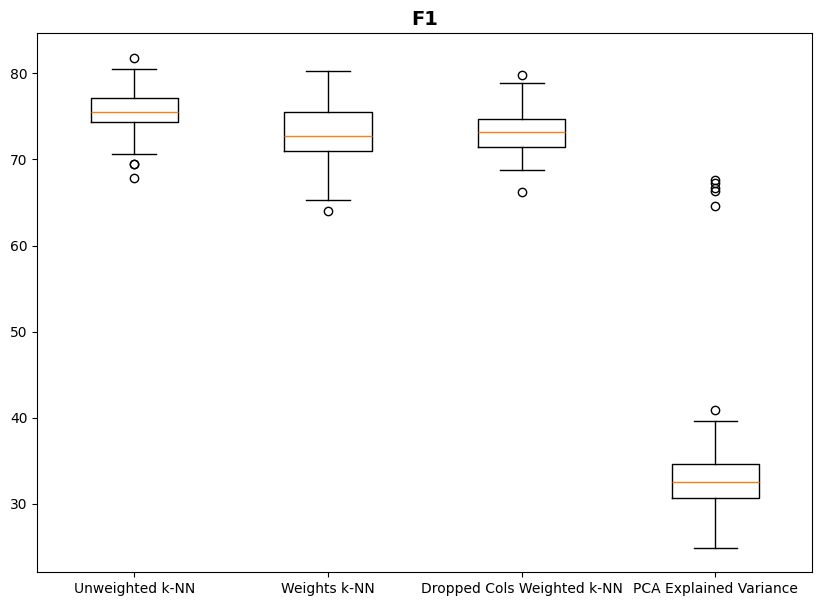

In [74]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [avg_f1,weight_avg_f1 ,dropped_weight_avg_f1,pca_explained_variance_f1]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

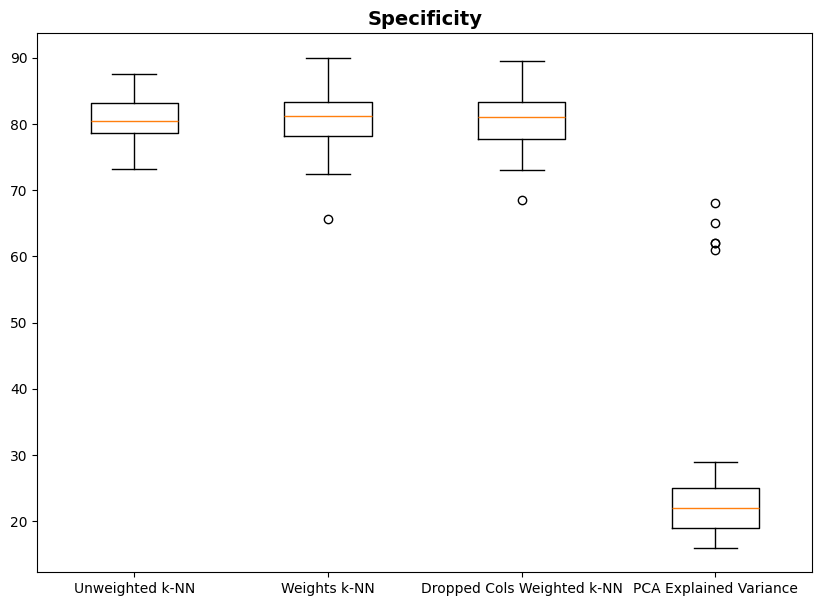

In [75]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [avg_specificity,weight_avg_specificity ,dropped_weight_avg_specificity,pca_explained_variance_specificity]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

In [76]:
min(data[0])

73.19587628865979

In [77]:
min(data[1])

65.71428571428571

In [78]:
min(data[2])

68.57142857142857

In [79]:
min(data[3])

16.0

In [80]:
max(data[0])

87.61904761904762

In [81]:
max(data[1])

90.0

In [82]:
max(data[2])

89.52380952380953

In [83]:
max(data[3])

68.0

In [84]:
pca = PCA(n_components=len(dropped_heart_X_train.columns))
pc = pca.fit_transform(dropped_heart_X_train)
pca2 = PCA(n_components=len(dropped_heart_X_test.columns))
pc2 = pca.fit_transform(dropped_heart_X_test)

In [85]:
pc

array([[ 2.29761958,  0.91152966,  0.8689247 , ...,  0.98218582,
        -1.0837747 ,  1.35495115],
       [-1.45438353,  0.41928448,  0.81660209, ...,  1.27998334,
        -0.12790812,  0.3534991 ],
       [ 4.23466093, -3.27888412,  1.16429286, ...,  0.52654841,
         0.83387135, -0.41586566],
       ...,
       [-1.74959499,  1.32571958, -0.82902647, ..., -0.01983371,
         0.60360071,  0.20606874],
       [-2.10324734,  0.22074255,  0.02374827, ...,  0.40986814,
        -0.28193511, -0.068513  ],
       [-2.01611407,  0.26455972,  0.01140763, ...,  0.35337959,
        -0.45333399, -0.10108925]])

In [86]:
dropped_heart_X_train.head()

,cp,thalach,exang,oldpeak,slope,ca,thal
0,0.872408,-1.813274,1.433497,0.381130,0.642696,2.474249,-0.892713
1,0.872408,1.194368,-0.695246,-0.905184,-0.974938,0.344243,-0.892713
2,0.872408,-0.200480,-0.695246,4.411580,2.260330,2.474249,1.170601
3,0.872408,-1.551739,1.433497,0.809901,0.642696,-0.720760,1.170601
4,0.872408,-0.767137,1.433497,0.638393,-0.974938,2.474249,1.170601


In [87]:
pc2

array([[-0.39902168,  0.19572554,  2.6423827 , ..., -0.5857098 ,
         0.29817937,  1.36035857],
       [-2.78165497,  0.41344947,  0.75703886, ...,  0.33061701,
         0.34378058,  0.0341382 ],
       [ 1.56242439,  1.05063183, -0.73994019, ..., -0.78013116,
         0.31180416,  0.19450794],
       ...,
       [ 1.04402468, -2.10287282, -0.51673009, ..., -0.4849918 ,
         0.69141534, -1.77824867],
       [ 1.80759364, -0.62019822,  0.12946713, ...,  0.26483438,
         0.26182429,  0.95925189],
       [ 2.54701084, -0.24016296,  0.13670979, ...,  0.30900895,
         0.4527988 ,  0.107807  ]])

In [88]:
df_pca = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 'principal component 5', 'principal component 6','principal component 7'])
df_pca2 = pd.DataFrame(data = pc2, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 'principal component 5', 'principal component 6','principal component 7'])


In [89]:
final_train_pca_df = pd.concat([df_pca, heart_y_train[['num']]], axis = 1)
final_test_pca_df = pd.concat([df_pca2, heart_y_train[['num']]], axis = 1)

In [90]:
final_train_pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,num
0,2.297620,0.911530,0.868925,-1.507919,0.982186,-1.083775,1.354951,1.0
1,-1.454384,0.419284,0.816602,0.953358,1.279983,-0.127908,0.353499,1.0
2,4.234661,-3.278884,1.164293,-0.154596,0.526548,0.833871,-0.415866,1.0
3,2.026359,0.723610,-1.750577,0.070963,-0.334193,-0.569144,-0.449582,1.0
4,2.301158,1.776605,1.460970,-0.354047,0.496841,0.475829,-0.358630,1.0


In [91]:
dropped_heart_X_train.head()

,cp,thalach,exang,oldpeak,slope,ca,thal
0,0.872408,-1.813274,1.433497,0.381130,0.642696,2.474249,-0.892713
1,0.872408,1.194368,-0.695246,-0.905184,-0.974938,0.344243,-0.892713
2,0.872408,-0.200480,-0.695246,4.411580,2.260330,2.474249,1.170601
3,0.872408,-1.551739,1.433497,0.809901,0.642696,-0.720760,1.170601
4,0.872408,-0.767137,1.433497,0.638393,-0.974938,2.474249,1.170601


In [92]:
heart_y_train.to_numpy().reshape(-1).flatten()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [93]:
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf_NN.fit(dropped_heart_X_train, heart_y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [94]:
clf_NN.predict(dropped_heart_X_test)

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [95]:
len(dropped_heart_X_test)

191

In [96]:
len(heart_y_test)

191

In [97]:
heart_y_test

,num
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
186,0.0
187,0.0
188,0.0
189,0.0


In [98]:
dropped_heart_X_test.head(300)

,cp,thalach,exang,oldpeak,slope,ca,thal
0,-0.164013,1.020012,-0.695246,1.838953,-0.974938,1.409246,1.170601
1,0.872408,-0.767137,1.433497,1.152918,0.642696,1.409246,1.170601
2,0.872408,0.845656,-0.695246,-0.905184,-0.974938,-0.720760,-0.892713
3,0.872408,-0.941493,-0.695246,1.324427,0.642696,-0.720760,1.170601
4,0.872408,0.366177,-0.695246,-0.905184,-0.974938,-0.720760,1.170601
...,...,...,...,...,...,...,...
186,-1.200433,1.063601,-0.695246,-0.905184,-0.974938,-0.720760,-0.892713
187,-1.200433,0.584122,-0.695246,-0.905184,-0.974938,-0.720760,1.170601
188,-1.200433,0.845656,-0.695246,-0.905184,2.260330,-0.720760,-0.892713
189,-1.200433,0.714889,-0.695246,0.123867,-0.974938,-0.720760,-0.892713


In [99]:
len(dropped_heart_X_train)

200

In [100]:
len(heart_y_train)

200

In [101]:
len(df_heart_standardized)

297

In [102]:
accuracy_score(clf_NN.predict(dropped_heart_X_test), heart_y_test)

0.7643979057591623

<h1 style=text-align:center;> Genetic Alogrithim

# Genetic Algorithm for K-Nearest Neighbors Weight Optimization

## Introduction

This document outlines the steps to optimize weights for a K-Nearest Neighbors (KNN) classifier using a genetic algorithm. The process involves creating multiple populations of weight sets, evaluating their performance, and iteratively refining them to improve the classifier's accuracy.

## Steps

### 1. Initialize Populations

- **Create 20 populations**:
  - Each population consists of a set of weights.
  - Initialize weights by multiplying the original weights by a random number between 0 and 1.

### 2. Evaluate Accuracy

- **Run KNN on each population**:
  - Split the dataset into training and testing sets.
  - Train the KNN classifier using the weights from each population.
  - Calculate the accuracy of each population on the test set.
  - Store the accuracy for each population.

### 3. Select Top Populations

- **Drop the bottom 10 populations**:
  - Sort the populations based on their accuracy.
  - Retain the top 10 populations and discard the bottom 10.

### 4. Duplicate Top Populations

- **Duplicate the top 10 populations**:
  - Create new populations by duplicating the top 10 populations.
  - This results in 20 populations again.

### 5. Apply Genetic Algorithm

- **Perform genetic operations**:
  - Apply crossover and mutation to the duplicated populations to introduce variations.
  - Ensure the new populations are different from the previous ones.

### 6. Repeat

- **Iterate the process**:
  - Repeat steps 2 to 5 for a predefined number of generations or until the accuracy converges.


In [108]:
heart_swagger

[np.float64(0.22030330000000004),
 np.float64(0.17796040000000002),
 np.float64(0.11807509999999997),
 np.float64(0.1486915),
 np.float64(0.1529283),
 np.float64(0.1955688),
 np.float64(0.34496180000000004)]

In [ ]:
# def weight_manipulation(num_of_population,num_of_weights,weights):
# 
#     genetic_weights = np.empty((num_of_population,num_of_weights))
# 
#     np_weights = np.array(weights)
# 
#     row, col = np_weights.shape
# 
#     if(col == 0):
# 
#         for i in range(0, np_weights.shape[0]):
#             genetic_weights[i] = weights[i] * np.random.rand(np_weights.shape[i])
# 
# 
#         genetic_weights = genetic_weights.reshape(-1,1)
# 
#         return genetic_weights
#     else :
# 
#         for i in range(0, np_weights.shape[0]):
#             genetic_weights[i] = weights[i] * np.random.rand(np_weights.shape[i])
# 
# 
#     return genetic_weights


In [411]:
def weight_manipulation(num_of_population,num_of_weights,weights):

    genetic_weights = np.empty((num_of_population,num_of_weights))
    
    np_weights = np.array(weights)
    
    # print("weights : ", np_weights.shape)
    # print("Chama: ", genetic_weights.shape)
    
    if(np_weights.ndim == 1):
    
        for i in range(0, num_of_population):
            genetic_weights[i] = weights * np.random.rand(len(weights))
        
        # print("Huh: " ,genetic_weights.shape)
        
        return genetic_weights
            
    else :

        for row in range(num_of_population):
            # Multiply each element in the row by a random factor
            # The random factor must have the same number of columns as the weight matrix
            genetic_weights[row] = np_weights[row] * np.random.rand(np_weights.shape[1])
        
    return genetic_weights
    

In [352]:
def get_weight_manipulated_acc(num_of_population, genetic_weights):

    population_data = []
    population_data_sorted = []

    for population in range(num_of_population):

        Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
        Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

        TP = TN = FP = FN =0

        for p in range(len(Test_Data)):
            point=Test_Data.iloc[p]
            NBRS=Nearest_Neighbors(point, Train_Data, genetic_weights[population] , "num")
            Label=KNN(3,NBRS)
            if (Label==point["num"] and Label==1):
                TP+=1
            if (Label==point["num"] and Label==0):
                TN+=1
            if (Label!=point["num"] and Label==1):
                FP+=1
            if (Label!=point["num"] and Label==0):
                FN+=1
        A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)

        accuracy = A_dropped_weighted*100

        accuracy_list.append(accuracy)

        population_weights_with_accuracy = np.append(genetic_weights[population], accuracy)
        population_data.append(population_weights_with_accuracy)
        population_data_sorted = sorted(population_data, key=lambda x: x[-1], reverse=True)
        
    return population_data_sorted

In [412]:
num_of_population = 20
num_of_weights = len(heart_swagger)

generations = 2

accuracy_list = []

# Dictionary to hold generations data
generations_data = {}
    
for gen_num in range(generations):
    
    if gen_num == 0:

        genetic_weights = weight_manipulation(num_of_population, num_of_weights,heart_swagger)
        
        population_data_sorted = get_weight_manipulated_acc(num_of_population, genetic_weights)
        generations_data[f'Generation_{gen_num + 1}'] = population_data_sorted
    else :

        population_data_sorted[-10:] = population_data_sorted[:10]

        for i in range(num_of_population):
            genetic_weights[i] = population_data_sorted[i][:7]

        genetic_weights = weight_manipulation(num_of_population, num_of_weights, genetic_weights)

        population_data_sorted = get_weight_manipulated_acc(num_of_population, genetic_weights)
        generations_data[f'Generation_{gen_num + 1}'] = population_data_sorted
    
    

In [314]:
genetic_weights

array([[1.28410063e-001, 1.13270814e-001, 7.72774867e-002,
        2.62527403e-002, 8.83246895e-002, 1.81132819e-001,
        4.72879213e-002],
       [6.94400828e-002, 3.25623603e-002, 1.68632356e-002,
        1.18344207e-001, 1.14274055e-001, 1.95142709e-001,
        3.34418162e-001],
       [7.50862319e-003, 1.37088151e-001, 4.23349206e-002,
        1.09112115e-001, 9.89801001e-002, 3.46916398e-002,
        2.32193158e-001],
       [1.64444001e-001, 2.82760137e-002, 7.63453113e-003,
        7.90219007e-002, 9.78108440e-002, 1.16745052e-001,
        2.16844887e-001],
       [1.33726222e-001, 5.82279151e-002, 5.28972113e-003,
        4.65339432e-003, 4.17197838e-002, 6.73370705e-002,
        2.37016530e-001],
       [1.16379878e-001, 1.22819240e-001, 4.40740721e-002,
        1.41800611e-001, 4.47596875e-002, 1.69580131e-001,
        4.76471612e-002],
       [1.67792013e-002, 1.73244337e-001, 2.48505316e-002,
        7.97466524e-002, 3.02492948e-002, 1.26200050e-001,
        1.39105340

In [315]:
for i in range(0,20):
    print(population_data[i][7])

74.3455497382199
75.39267015706807
74.86910994764398
71.72774869109948
72.77486910994764
70.68062827225131
79.58115183246073
75.91623036649214
76.43979057591623
74.86910994764398
65.96858638743456
70.68062827225131
78.01047120418848
67.5392670157068
68.06282722513089
72.25130890052355
73.29842931937172
74.86910994764398
77.4869109947644
74.86910994764398


In [316]:
for i in range(0,20):
    print(population_data_sorted[i][7])

79.58115183246073
78.53403141361257
78.53403141361257
76.43979057591623
75.91623036649214
71.72774869109948
67.5392670157068
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937
46.07329842931937


In [244]:
population_data_sorted[:10]

[array([7.18737654e-02, 2.80033927e-02, 6.90250153e-02, 2.26485675e-02,
        4.41542713e-02, 1.82369907e-01, 8.49128207e-02, 8.06282723e+01]),
 array([1.17765583e-01, 2.14407913e-02, 3.58392772e-02, 3.44907622e-02,
        2.29978459e-02, 1.55308275e-01, 2.82530911e-01, 8.01047120e+01]),
 array([2.03785998e-01, 9.93753554e-02, 3.95237935e-02, 2.26783977e-02,
        1.15017563e-01, 1.66327466e-01, 1.89404809e-01, 7.80104712e+01]),
 array([1.57147880e-01, 1.47858884e-01, 8.10338298e-02, 3.03388217e-02,
        3.82235845e-02, 1.66498233e-01, 3.37039150e-01, 7.74869110e+01]),
 array([1.43820947e-01, 8.53644979e-02, 1.05632727e-01, 5.10829741e-02,
        1.17898292e-01, 1.84389155e-01, 2.60620370e-01, 7.64397906e+01]),
 array([1.98751040e-01, 2.28403133e-02, 2.18951555e-02, 3.94409991e-02,
        1.14287601e-01, 6.16254547e-02, 2.38939088e-01, 7.64397906e+01]),
 array([2.20232729e-01, 1.30763784e-01, 1.16483779e-03, 8.82171702e-02,
        1.38550358e-01, 6.55943623e-02, 2.46899517e-

In [416]:
population_data_sorted[-10:] = population_data_sorted[:10]

In [246]:
for i in range(0,20):
    print(population_data_sorted[i][7])

80.6282722513089
80.10471204188482
78.01047120418848
77.4869109947644
76.43979057591623
76.43979057591623
75.91623036649214
74.86910994764398
74.86910994764398
73.82198952879581
80.6282722513089
80.10471204188482
78.01047120418848
77.4869109947644
76.43979057591623
76.43979057591623
75.91623036649214
74.86910994764398
74.86910994764398
73.82198952879581


In [421]:
for i in range(0,20):
    print(generations_data["Generation_1"][i][7])

79.05759162303664
77.4869109947644
77.4869109947644
76.96335078534031
76.43979057591623
76.43979057591623
76.43979057591623
74.86910994764398
74.3455497382199
73.82198952879581
79.05759162303664
77.4869109947644
77.4869109947644
76.96335078534031
76.43979057591623
76.43979057591623
76.43979057591623
74.86910994764398
74.3455497382199
73.82198952879581


In [420]:
for i in range(0,20):
    print(generations_data["Generation_2"][i][7])

79.58115183246073
78.53403141361257
78.01047120418848
77.4869109947644
77.4869109947644
77.4869109947644
76.96335078534031
76.96335078534031
76.43979057591623
75.39267015706807
79.58115183246073
78.53403141361257
78.01047120418848
77.4869109947644
77.4869109947644
77.4869109947644
76.96335078534031
76.96335078534031
76.43979057591623
75.39267015706807
